**TP 4 Apprentissage multi-niveau de bruits, Unet, Mnist**


**Exercice 1:** (conditionnement par le bruit) 
Construire un réseau de neurones `pot` (MLP) $\mathbb{R}^3 \rightarrow \mathbb{R}$ et `grad` (MLP) $\mathbb{R}^3 \rightarrow \mathbb{R}^2$ qui vont servir à apprendre  respectivement la densité (potentiel) et le score (son gradient) conditionnés par une valeur de bruit. 

In [70]:
import torch
from torch import nn        #neuronal network
from torch import optim     #descente de gradient
from sklearn.model_selection import train_test_split        #split into train and test set
from torch.utils.data import DataLoader
import itertools
import numpy as np

In [71]:
## on ajoute un paramètre, car pot et grad sont maintenant de R^3 au lieu de R^2.
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.dropout = nn.Dropout(0.2)
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        nn.init.kaiming_uniform_(self.layer_1.weight, nonlinearity="relu")
        self.layer_2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        self.dropout = nn.Dropout(0.2)
        #take max(0,x)
        x = torch.nn.functional.relu(self.layer_1(x))
        self.dropout = nn.Dropout(0.2)
        #limit the amplitudes to 1
        x = torch.nn.functional.sigmoid(self.layer_2(x))

        return x

In [72]:
input_dim = 3       #input layer with 3 neurons
hidden_dim = 10     #hidden layer with 10 neurons
output_dim = 2

In [73]:
#instantiate a model of NN class for density estimation
model = NeuralNetwork(input_dim, hidden_dim, output_dim)
print(model)

#alpha = step-size in direction of gradient
learning_rate = 0.1
#loss function giving error between real and estimated data
loss_fn = nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

NeuralNetwork(
  (dropout): Dropout(p=0.2, inplace=False)
  (layer_1): Linear(in_features=3, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=2, bias=True)
)


**Exercice 2:** (apprentissage multi-bruit du score)
En s'inspirant de l'exercice 6 du TP 3 et en basant sur la méthode vue en cours, apprendre à un réseau de neurones à prédire l'inverse du bruit qui est rajouté à un point des données, conditionné par le niveau de bruit appliqué. Faire une représentation du champs de vecteur associé.

In [74]:
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
from torch.distributions.multivariate_normal import MultivariateNormal

In [75]:
def deux_bosses(mean_1, mean_2, cov_1, cov_2, n):
    data_1 = np.random.multivariate_normal(mean_1, cov_1, size=n//2)
    data_2 = np.random.multivariate_normal(mean_2, cov_2, size=n//2)
    return np.concatenate((data_1, data_2))

(2000, 2)


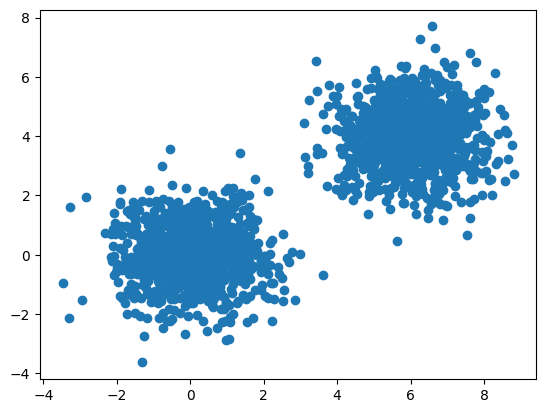

In [76]:
#create dataset
samples = deux_bosses([0, 0], [6, 4], [[1, 0], [0, 1]], [[1, 0], [0, 1]], 2000)
print(samples.shape)
plt.scatter(samples[:,0], samples[:,1])

In [77]:
#split dataset in train and test

X_train, X_test = train_test_split(samples,test_size=.33, random_state=26)

In [78]:
#enables to create different batches instead of treating whole dataset taking too much CPU

# Convert data to torch tensors
class Data():
    def __init__(self, X):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.len = self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index]

    def __len__(self):
        return self.len

In [79]:
#set batch size for first model
batch_size = 64

# Instantiate training and test data
train_data = Data(X_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = Data(X_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

# Check it's working
for batch, X in enumerate(train_dataloader):
    print(f"Batch: {batch+1}")
    print(f"X shape: {X.shape}")
    break

Batch: 1
X shape: torch.Size([64, 2])


In [80]:
mean = torch.Tensor([0,0])
cov2 = torch.Tensor([[1, 0], [0, 1]])
distrib = MultivariateNormal(loc=mean, covariance_matrix=cov2)
distrib.rsample(sample_shape=torch.Size([100, 2]))

tensor([[[ 5.1351e-01, -1.3880e+00],
         [ 7.8124e-01,  8.9129e-01]],

        [[ 9.0663e-01, -6.7306e-02],
         [-8.6601e-01, -5.0315e-01]],

        [[-1.0667e+00, -5.9810e-01],
         [-9.8509e-01,  1.7460e+00]],

        [[-1.6097e-01, -1.0133e+00],
         [-7.4350e-01, -6.9455e-02]],

        [[ 2.1266e-01, -1.5458e+00],
         [ 5.0913e-01,  5.8411e-01]],

        [[ 1.2365e+00,  7.0418e-01],
         [ 1.5770e+00,  7.9258e-01]],

        [[ 1.8382e+00, -1.2904e+00],
         [-8.0471e-01,  4.1236e-01]],

        [[-1.3283e+00, -4.6072e-01],
         [ 1.0312e+00, -5.3336e-01]],

        [[-1.2203e+00, -4.1464e-01],
         [ 8.0624e-01,  2.2350e-01]],

        [[ 1.1059e+00,  3.0461e-01],
         [-4.8825e-02,  1.1961e-01]],

        [[ 1.0838e+00,  1.5339e-01],
         [-2.3004e-01,  8.0568e-01]],

        [[ 1.5444e+00, -6.1874e-01],
         [ 1.4288e+00,  1.4865e+00]],

        [[-2.0623e-01, -1.8117e-01],
         [-2.0768e-02, -8.8178e-02]],

        [[ 1

In [81]:
# 2. model pour grads

input_dim_grad = 3       #input layer with 3 neurons
hidden_dim_grad = 10     #hidden layer with 10 neurons
output_dim_grad = 2      #output layer with 2 neuron

class NeuralNetworkGrad(nn.Module):
    def __init__(self, input_dim_grad, hidden_dim_grad, output_dim_grad):
        super(NeuralNetworkGrad, self).__init__()
        self.dropout = nn.Dropout(0.2)
        self.layer_1 = nn.Linear(input_dim_grad, hidden_dim_grad)
        self.layer_2 = nn.Linear(hidden_dim_grad, output_dim_grad)

    def forward(self, x):
        x = torch.nn.functional.relu(self.layer_1(x))
        x = self.dropout(x) #apply dropout correctly
        x = self.layer_2(x)

        return x

#instantiate a model of NN class
modelGrad = NeuralNetworkGrad(input_dim_grad, hidden_dim_grad, output_dim_grad)
print(modelGrad)

NeuralNetworkGrad(
  (dropout): Dropout(p=0.2, inplace=False)
  (layer_1): Linear(in_features=3, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=2, bias=True)
)


In [82]:
#alpha = step-size in direction of gradient
learning_rate = 0.01
#loss function giving error between real and estimated data
loss_fn = nn.MSELoss()

optimizer_grad = torch.optim.SGD(modelGrad.parameters(), lr=learning_rate)

In [83]:
#compute average
sampav=np.average(samples, axis=0)

#compute maximal distance between average and all points in datasets
def maxdistance(dataset):
    #compute average
    average=np.average(samples, axis=0)
    dist = np.linalg.norm(average - dataset[0])
    for tup in range(len(dataset)):
        disttemp =np.linalg.norm(average-dataset[tup])
        if disttemp >dist:
            dist = disttemp
    return dist


#compute sigma_t
def sigmat(dataset,t):
    sigmaMin=0.01
    maxdist = maxdistance(dataset)
    sigmaMax = 2*maxdist
    return sigmaMin*((sigmaMax/sigmaMin)**t)
def sample_batch(dataset,n):
    sigmas=[]
    times=np.random.rand(n)

    for i in range(0,len(times)):
        sigmas.append(sigmat(dataset,times[i]))
    return torch.Tensor(sigmas)


print(sample_batch(samples,10))

tensor([3.4427, 0.0776, 0.0531, 0.0236, 0.0818, 2.0348, 4.1571, 5.9305, 1.7476,
        6.1400])


In [84]:
#Train the model
num_epochs = 1
loss_values_grad = []

for epoch in range(num_epochs):
    for X in train_dataloader:

        # zero the parameter gradients

        optimizer_grad.zero_grad()

        # forward + backward + optimize
        #we sample a batch of bruit niveau
        batch_amplitude_bruit=sample_batch(samples,torch.Size([X.shape[0]])[0])
        #reparametrization trick

        bruit=distrib.rsample(sample_shape=torch.Size([X.shape[0]]))
        bruit=bruit*batch_amplitude_bruit[:,None]

        Xnoise=torch.add(X,bruit)
        noise = batch_amplitude_bruit.unsqueeze(1)
        Xinput = torch.cat([Xnoise,noise],dim=1)
        pred = modelGrad(Xinput)
        loss = loss_fn(pred,-bruit)
        loss_values_grad.append(loss.item())
        loss.backward()
        optimizer_grad.step()

print("Training Complete")

Training Complete


In [85]:
def torch_ls(fon, p, n, epsi):
    point = p
    tensor = point
    mu1=torch.Tensor([[epsi, 0],[0, epsi]])
    mean = torch.Tensor([0,0])
    distrib = MultivariateNormal(loc=mean, covariance_matrix=mu1)
    for i in range(n):
        # Ensure that point has 3 features: [x1, x2, epsi]
        pointnoise = torch.cat([point, torch.ones(point.shape[0], 1) * epsi], dim=1)  # Add noise level to point
        # Add noise and apply function
        modeloutput=fon(pointnoise)
        #remove noise before adding model output
        point = point + modeloutput + distrib.rsample(sample_shape=torch.Size([point.shape[0]]))
        #concatenate to the tensor
        tensor=torch.cat((tensor,point))

    return tensor

liste=torch_ls(modelGrad,torch.Tensor([[0,4],[2,3]]),100,0.01)

In [86]:
import matplotlib.animation as animation
from IPython.display import HTML

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


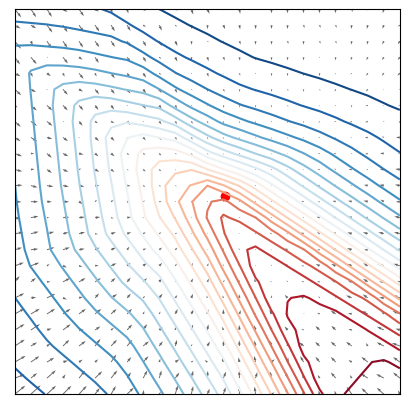

In [93]:
# Params
initial_points = torch.Tensor([[0,4],[2,3]])
steps = 30
bounds = 5
epsi = 0.01

# Generate points trajectory
points = torch_ls(modelGrad, initial_points, steps, epsi) 

# Set up the figure
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(-bounds, bounds)
ax.set_ylim(-bounds, bounds)
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')

# Generate the vector field
absc = np.linspace(-bounds, bounds, 25)
ordo = np.linspace(-bounds, bounds, 25)
X, Y = np.meshgrid(absc, ordo)

grid_points = torch.tensor(np.c_[X.ravel(), Y.ravel()], dtype=torch.float32)
grid_points = torch.cat([grid_points, torch.ones(grid_points.shape[0], 1) * epsi], dim=1)

with torch.no_grad():
    directions = modelGrad(grid_points)                  #learn gradient vectors
    density = model(grid_points)[:, 0].detach().cpu().numpy() #learn density values

U = directions[:, 0].detach().numpy().reshape(X.shape)
V = directions[:, 1].detach().numpy().reshape(Y.shape)

ax.quiver(X, Y, U, V, color="black", alpha=0.6, scale=20, scale_units='xy')

# Density contour
Z = density.reshape(X.shape)
ax.contour(X, Y, Z, levels=20, cmap='RdBu') 

# Initial scatter plot
scatter = ax.scatter(points[:, 0].detach().numpy(), points[:, 1].detach().numpy(), color='red')

# Animation update function
def update(frame):
    scatter.set_offsets(points[frame,:].detach().numpy())
    return (scatter,)

# Animate
ani = animation.FuncAnimation(fig, update, frames=steps + 1, interval=100, blit=True)

from IPython.display import HTML
HTML(ani.to_jshtml())

**Exercice 3:** (champ de vecteur en grande dimension)
Nous souhaitons appliquer la méthode ci-dessus à des images $28\times 28$ (dataset mnist). Nous voulons donc pour cela utiliser une architecture Unet. Construire un réseau de neurone `gradU` (Unet) $\mathbb{R}^{28\times 28} \rightarrow \mathbb{R}^{28\times 28}$

In [ ]:
m= nn.Conv2d(1, 4, kernel_size=4, padding=0, stride=2)

input = torch.randn(1,28,28)
output = m(input)
#output.shape

m2=nn.Conv2d(4, 8, kernel_size=4, padding=0, stride=2)
output2=m2(output)
#output2.shape

m3=nn.ConvTranspose2d(8, 4, kernel_size=4, stride=2)
m4= nn.ConvTranspose2d(4, 1, kernel_size=4, stride=2)

output3=m3(output2)
output4=m4(output3)
#output3.shape
#output4.shape

In [ ]:
class UNet_simple(nn.Module):
    def __init__(self, channels=[32, 64, 128, 256], embed_dim=256,
               text_dim=256):
        super().__init__()

        # Other model properties
        self.act = nn.SiLU()

        # Encoding layers
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)

        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])


        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])


        # Decoding layers
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

        self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)

        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

        self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)

        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])

        self.tconv1 = nn.ConvTranspose2d(channels[0], 1, 3, stride=1)


    def forward(self, x):

        # Encoding
        h1 = self.act(self.gnorm1(self.conv1(x) ))
        h2 = self.act(self.gnorm2(self.conv2(h1) ))
        h3 = self.act(self.gnorm3(self.conv3(h2) ))
        h4 = self.act(self.gnorm4(self.conv4(h3) ))


        # Decoding
        h = self.act(self.tgnorm4(self.tconv4(h4) ))
        h = self.act(self.tgnorm3(self.tconv3(h + h3) ))
        h = self.act(self.tgnorm2(self.tconv2(h + h2) ))
        h = self.tconv1(h + h1)

        return h

modelGradU = UNet_simple()

**Exercice 4:** (estimation naive du score)
En se basant sur la méthode vue à l'exercice 6 du TP 3, apprendre au réseau `gradU` à prédire l'inverse du bruit qui est rajouté à un point des données mnist.

In [ ]:
import torchvision
from torchvision import transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

batch_size = 4
trainset = torchvision.datasets.MNIST(root='./data/', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data/', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
for X in trainloader:
  modelGradU(X[0])
  print(modelGradU(X[0]).shape)
  break

In [ ]:
#alpha = step-size in direction of gradient
learning_rate = 0.01
#loss function giving error between real and estimated data
loss_fn = nn.MSELoss()

optimizer_gradU = torch.optim.SGD(modelGradU.parameters(), lr=learning_rate)

meanU = torch.zeros(28*28)
covU = torch.eye(28*28)
distribU = MultivariateNormal(loc=meanU, covariance_matrix=covU)
distribU.rsample(sample_shape=torch.Size([100, 28*28]))

#Train the model
num_epochs = 1
loss_values_grad = []

for epoch in range(num_epochs):
    for X in trainloader:
        X=X[0]
        #print(torch.Size([X.shape[0]])[0])
        # zero the parameter gradients

        optimizer_gradU.zero_grad()


        # forward + backward + optimize
        #on sample un batch de niveau de bruit
        batch_amplitude_bruit=sample_batch(samples,torch.Size([X.shape[0]])[0])
        #print(batch_amplitude_bruit)
        #reparametrization trick

        bruit=distrib.rsample(sample_shape=torch.Size([X.shape[0]]))
        #print(X.shape[0])
        #print(bruit.shape)
        #print(batch_amplitude_bruit.shape)
        bruit=bruit*batch_amplitude_bruit[:,None]

        #print(bruit.shape)
        #print(X.shape)
        #print(torch.add(X,bruit.view(4,2,1,1)).shape)
        #print(bruit)
        #print(X)
        #print(torch.add(X,bruit.view(4,2,1,1)))
        pred = modelGradU(torch.add(X,bruit.view(4,2,1,1))[:, :1, :, :]) #torch.add to add bruit for every batch to all of 28x28 pixels.
                                                                         #have 8 values in bruit, thus 2 Channels, then keep only the first Channel with [:, :1, :, :].
        loss = loss_fn(pred,-bruit.view(4,2,1,1))     #need to correclty "view" bruit as 4,2,1,1 tensor.
        loss_values_grad.append(loss.item())
        loss.backward()
        optimizer_gradU.step()

print("Training Complete")

**Exercice 5:** (inférence par dynamique langevienne et visualisation)
En s'inspirant de l'exercice 3 du TP 3, écrire une fonction `langevin_sample(fon,n)` qui prend en paramètre une fonction `fon`$:\mathbb{R}^{28\times 28}\rightarrow\mathbb{R}^{28\times 28}$ et échantillone un élément suivant cette densité en échantillon un point de $\mathbb{R}^{28\times 28}$ selon une loi normale puis effectue n pas à l'aide du schéma numérique d'Euler, en ajoutant à chaque pas une petite perturbation tirée selon une loi normale. Faire une matrice avec en ligne 10 points dans la courbe intégrale d'un échantillon et en colonne les courbes intégralles de 10 échantillons.

In [ ]:
## coder ici

**Exercice 6:** (conditionnement par le bruit) 
Construire un réseau de neurones `gradUmulti` (Unet) $\mathbb{R}^{28\times 28+1} \rightarrow \mathbb{R}^{28\times 28}$ qui va servir à apprendre  le score conditionné par une valeur de bruit. 

In [ ]:
## coder ici

**Exercice 7:** (apprentissage multi-bruit du score)
En s'inspirant de l'exercice 2, apprendre au réseau `gradUmulti` à prédire l'inverse du bruit qui est rajouté à un point des données, conditionné par le niveau de bruit appliqué.

In [ ]:
## coder ici

**Exercice 8:** (inférence par dynamique langevienne)
En s'inspirant de l'exercice 5, écrire une fonction `langevin_sample_schedule(fon,n)` qui prend en paramètre une fonction `fon`$:\mathbb{R}^{28\times 28+1}\rightarrow\mathbb{R}^{28\times 28}$ et échantillone un élément suivant la distribution des données. Pour ce faire, elle échantillonne un point de $\mathbb{R}^{28\times 28}$ selon une loi normale puis effectue n pas à l'aide du schéma numérique d'Euler, en ajoutant à chaque pas une petite perturbation tirée selon une loi normale, en prenant soin de de choisir le niveau de bruit en fonction d'un scheduler. Sampler et représenter 10 courbes intégrales.

In [ ]:
## coder ici